In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv
/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Artificial_Crystals_Dataset.csv
/kaggle/input/playground-series-s3e25/sample_submission.csv
/kaggle/input/playground-series-s3e25/train.csv
/kaggle/input/playground-series-s3e25/test.csv


![](https://i0.wp.com/www.compoundchem.com/wp-content/uploads/2022/11/Mohs-Hardness-Scale.png?ssl=1)

# <span style="color: ForestGreen">Table of Contents</span>

1. [Import libraries](#1)
2. [Open data files](#2)
3. [Show first 5 lines of train data](#3)
    - 3.1 [Compare original train and competition train](#3.1)
    - 3.2 [Concatenate original train with competition train](#3.2)
4. [Shapes of train and test data](#4)
5. [Display descriptive statistics of train data](#5)
6. [Check the number of gaps for each feature](#6)
7. [Data types of training set](#7)
    - 7.1 [Figure out how much duplicates in data](#7.1)
    - 7.2 [Remove duplicates from train data](#7.2)
8. [Display histograms of distribution](#8)
9. [Let's count target of train data](#9)
10. [Transorm the data with logarithm](#10)
    - 10.1 [Pie plot of smoking](#10.1)
    - 10.2 [Feature importance](#10.2)
11. [Build a heat map of correlations](#11)
12. [Define base models](#12)
13. [Defining the meta-model](#13)
14. [Creating and fitting the stacking model](#14)
15. [Predict the validation set and calculate Median Absolute Error score](#15)
16. [Predict on the test data](#16)
17. [Build DataFrame and make first submission](#17)


<font face="Bahnschrift Condensed" style="font-size: 14pt;">Hardness, or the quantitative value of resistance to permanent or plastic deformation, plays a very crucial role in materials design in many applications, such as ceramic coatings and abrasives. Hardness testing is an especially useful method as it is non-destructive and simple to implement to gauge the plastic properties of a material. In this study, I proposed a machine, or statistical, learning approach to predict hardness in naturally occurring materials, which integrates atomic and electronic features from composition directly across a wide variety of mineral compositions and crystal systems. First, atomic and electronic features from the composition, such as van der Waals and covalent radii as well as the number of valence electrons, were extracted from the composition.
</font>
<br><br>
<font face="Bahnschrift Condensed" style="font-size: 14pt;">In this study, the author trained a set of classifiers to understand whether compositional features can be used to predict the Mohs hardness of minerals of different chemical spaces, crystal structures, and crystal classes. The dataset for training and testing the classification models used in this study originated from experimental Mohs hardness data, their crystal classes, and chemical compositions of naturally occurring minerals reported in the Physical and Optical Properties of Minerals CRC Handbook of Chemistry and Physics and the American Mineralogist Crystal Structure Database. The database is composed of 369 uniquely named minerals. Due to the presence of multiple composition combinations for minerals referred to by the same name, the first step was to perform compositional permutations on these minerals. This produced a database of 622 minerals of unique compositions, comprising 210 monoclinic, 96 rhombohedral, 89 hexagonal, 80 tetragonal, 73 cubic, 50 orthorhombic, 22 triclinic, 1 trigonal, and 1 amorphous structure. An independent dataset was compiled to validate the model performance. The validation dataset contains the composition, crystal structure, and Mohs hardness values of 51 synthetic single crystals reported in the literature. The validation dataset includes 15 monoclinic, 7 tetragonal, 7 hexagonal, 6 orthorhombic, 4 cubic, and 3 rhombohedral crystal structures.
</font>
<br><br>
<font face="Bahnschrift Condensed" style="font-size: 14pt;">In this study, the author constructed a database of compositional feature descriptors that characterize naturally occurring materials obtained directly from the Physical and Optical Properties of Minerals CRC Handbook45. This comprehensive compositional-based dataset allows us to train models that are able to predict hardness across a wide variety of mineral compositions and crystal classes. Each material in both the naturally occurring mineral and artificial single crystal datasets was represented by 11 atomic descriptors. The elemental features are the number of electrons, number of valence electrons, atomic number, Pauling electronegativity of the most common oxidation state, covalent atomic radii, van der Waals radii, and ionization energy of neutral.


![](https://i0.wp.com/www.trigonalsystem.com/wp-content/uploads/2021/05/07.jpg?resize=1024%2C606&ssl=1)

<a id='1'></a>
# <span style="color: brown">1 - Import libraries</span>

In [2]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import median_absolute_error

<a id='2'></a>
# <span style="color: brown">2 - Open data files</span>

In [3]:
original_train = pd.read_csv('/kaggle/input/prediction-of-mohs-hardness-with-machine-learning/jm79zfps6b-1/Mineral_Dataset_Supplementary_Info.csv')

train = pd.read_csv('/kaggle/input/playground-series-s3e25/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s3e25/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e25/sample_submission.csv')

<a id='3'></a>
# <span style="color: brown">3 - Show first 5 lines of train data</span>

In [4]:
# Show all properties on display
pd.set_option('display.max_columns', None)

train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


<a id='3.1'></a>
### <span style="color: brown">3.1 Compare original train and competition train</span>

In [5]:
print(original_train.shape)
original_train.columns.tolist()

(622, 13)


['Unnamed: 0',
 'Hardness',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average']

In [6]:
print(train.shape)
train.columns.tolist()

(10407, 13)


['id',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness']

<a id='3.2'></a>
### <span style="color: brown">3.2 Concatenate original train with competition train</span>

In [7]:
train = pd.concat(objs=[train, original_train]).reset_index(drop=True)
train.shape

(11029, 14)

In [8]:
train.columns.tolist()

['id',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness',
 'Unnamed: 0']

In [9]:
train = train.drop(['id', 'Unnamed: 0'], axis=1)
test.drop(columns='id', axis=1, inplace=True)
train.columns.tolist()

['allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness']

<a id='4'></a>
# <span style="color: brown">4 - Shapes of train and test data</span>

In [10]:
print(f'Train data: {train.shape}')
print(f'Test data: {test.shape}\n')

train_data_percentage = np.round(train.shape[0] / (train.shape[0] + test.shape[0]), 4)
print(f'Train data consists of {train_data_percentage * 100}% of all observations')
print(f'Test data consists of {(1 - train_data_percentage) * 100}% of all observations')

Train data: (11029, 12)
Test data: (6939, 11)

Train data consists of 61.38% of all observations
Test data consists of 38.62% of all observations


<a id='5'></a>
# <span style="color: brown">5 - Display descriptive statistics of train data</span>

In [11]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
allelectrons_Total,11029.0,138.478018,300.368288,0.0,68.000000,100.000000,138.000000,15300.000000
density_Total,11029.0,15.245564,18.357166,0.0,7.558488,11.073072,17.590000,643.093804
allelectrons_Average,11029.0,16.907728,10.453091,0.0,10.000000,12.500000,21.833333,67.000000
val_e_Average,11029.0,4.539603,0.698567,0.0,4.000000,4.700000,4.800000,6.000000
atomicweight_Average,11029.0,37.210823,25.961319,0.0,20.298893,26.164726,48.719500,167.400000
ionenergy_Average,11029.0,10.947921,1.430073,0.0,10.599905,11.221459,11.688350,15.245810
el_neg_chi_Average,11029.0,2.608727,0.339107,0.0,2.530000,2.706000,2.805000,3.443000
R_vdw_element_Average,11029.0,1.727907,0.197129,0.0,1.672500,1.732000,1.797813,2.250000
R_cov_element_Average,11029.0,0.940243,0.181762,0.0,0.864000,0.914286,0.980000,1.615840
zaratio_Average,11029.0,0.494563,0.065491,0.0,0.476196,0.489272,0.496606,0.825990


#### <span style="color: ForestGreen">allelectrons_Total, density_Total features here contain several values ​​that are much greater than the 3rd quantile</span>

<a id='6'></a>
# <span style="color: brown">6 - Check the number of gaps for each feature</span>

In [12]:
print('TRAIN data\n')
print(f'{train.isna().sum()}\n\n\n')

print('TEST data\n')
print(train.isna().sum())

TRAIN data

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64



TEST data

allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64


#### <span style="color: ForestGreen">As we can see, there are no preliminary gaps in the data. However, sometimes it is useful to check the unique values ​​for each characteristic. After all, the gaps could be filled with a '?' and then the .isna() method will not notice them</span>

<a id='7'></a>
# <span style="color: brown">7 - Data types of training set</span>

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11029 entries, 0 to 11028
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   allelectrons_Total     11029 non-null  float64
 1   density_Total          11029 non-null  float64
 2   allelectrons_Average   11029 non-null  float64
 3   val_e_Average          11029 non-null  float64
 4   atomicweight_Average   11029 non-null  float64
 5   ionenergy_Average      11029 non-null  float64
 6   el_neg_chi_Average     11029 non-null  float64
 7   R_vdw_element_Average  11029 non-null  float64
 8   R_cov_element_Average  11029 non-null  float64
 9   zaratio_Average        11029 non-null  float64
 10  density_Average        11029 non-null  float64
 11  Hardness               11029 non-null  float64
dtypes: float64(12)
memory usage: 1.0 MB


#### <span style="color: ForestGreen">As You can see, all data types are numeric, so if there are gaps, they were most likely filled with some kind of numeric values ​​like 0, median or average value</span>

<a id="7.1"></a>
### <span style="color: brown">7.1 Figure out how much duplicates in data</span>

In [14]:
train_duplicates_number = train[train.duplicated()]
                             
print(len(train_duplicates_number))

23


#### <span style="color: ForestGreen">There are 23 duplicates in train data. Let's remove them!</span>

<a id="7.2"></a>
### <span style="color: brown">7.2 Remove duplicates from train data</span>

In [15]:
train = train.drop_duplicates()

# Check whether all duplicates were removed
duplicates = train[train.duplicated()]
len(duplicates)

0

<a id='8'></a>
# <span style="color: brown">8 - Display histograms of distribution</span>

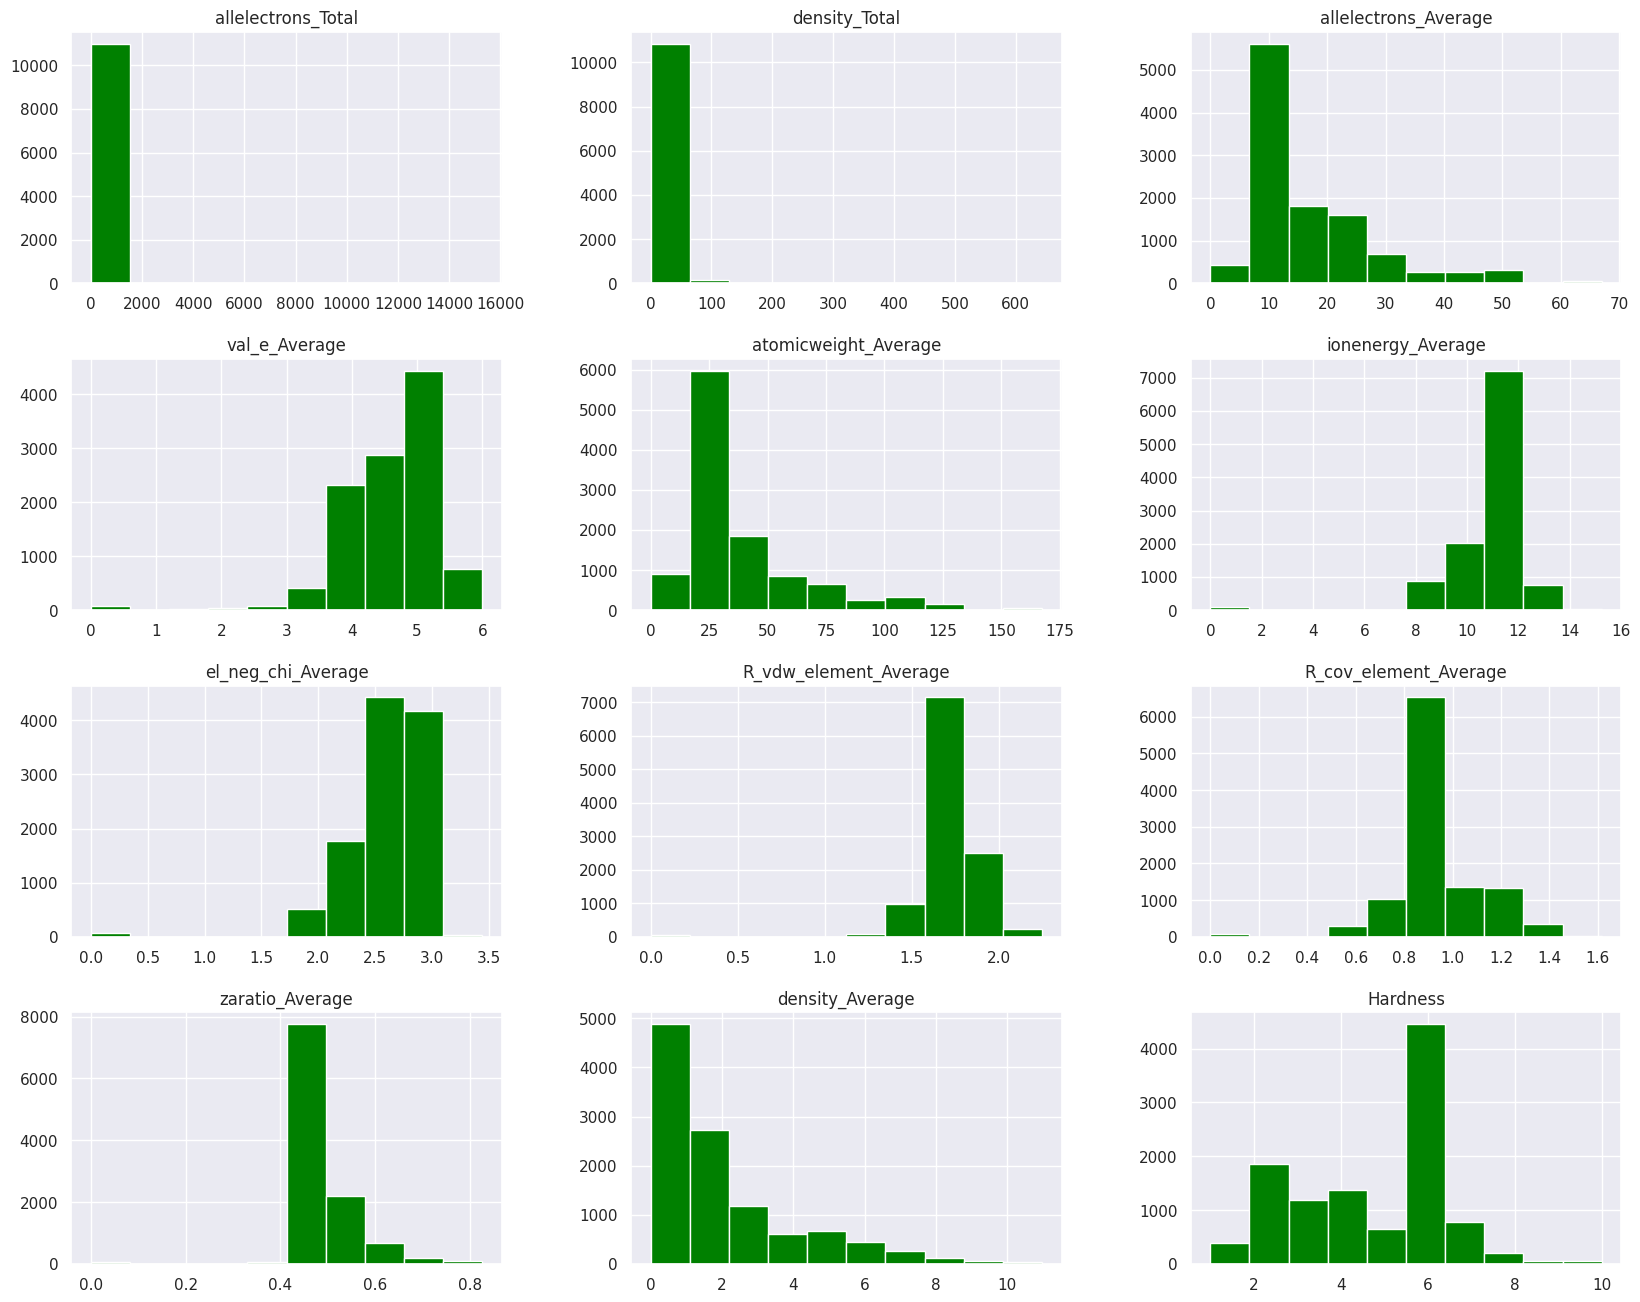

In [16]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='green');

<a id='9'></a>
# <span style="color: brown">9 - Let's count target of train data</span>

In [17]:
print(f'{train.Hardness.value_counts()}\n\n')
print(train.Hardness.value_counts() / train.shape[0])

Hardness
6.00     2128
5.50     1573
2.50     1126
3.80      741
5.80      449
6.50      418
2.80      415
2.00      412
5.00      392
4.00      380
3.00      321
2.30      307
3.50      291
6.30      281
6.80      254
1.50      200
1.80      167
3.30      156
5.30      146
4.30      137
4.80      113
4.50      109
7.00      107
7.50      106
7.80       72
9.00       34
10.00      31
9.50       26
1.30       20
8.50       16
8.00       14
6.20       11
7.30       11
5.75       10
2.90        7
8.10        7
1.00        3
3.60        2
3.20        2
8.30        1
5.40        1
6.70        1
2.60        1
4.10        1
2.20        1
4.70        1
6.40        1
9.80        1
2.10        1
6.64        1
Name: count, dtype: int64


Hardness
6.00     0.193349
5.50     0.142922
2.50     0.102308
3.80     0.067327
5.80     0.040796
6.50     0.037979
2.80     0.037707
2.00     0.037434
5.00     0.035617
4.00     0.034527
3.00     0.029166
2.30     0.027894
3.50     0.026440
6.30     0.025532
6.

<a id='10'></a>
# <span style="color: brown">10 - Transorm the data with logarithm</span>

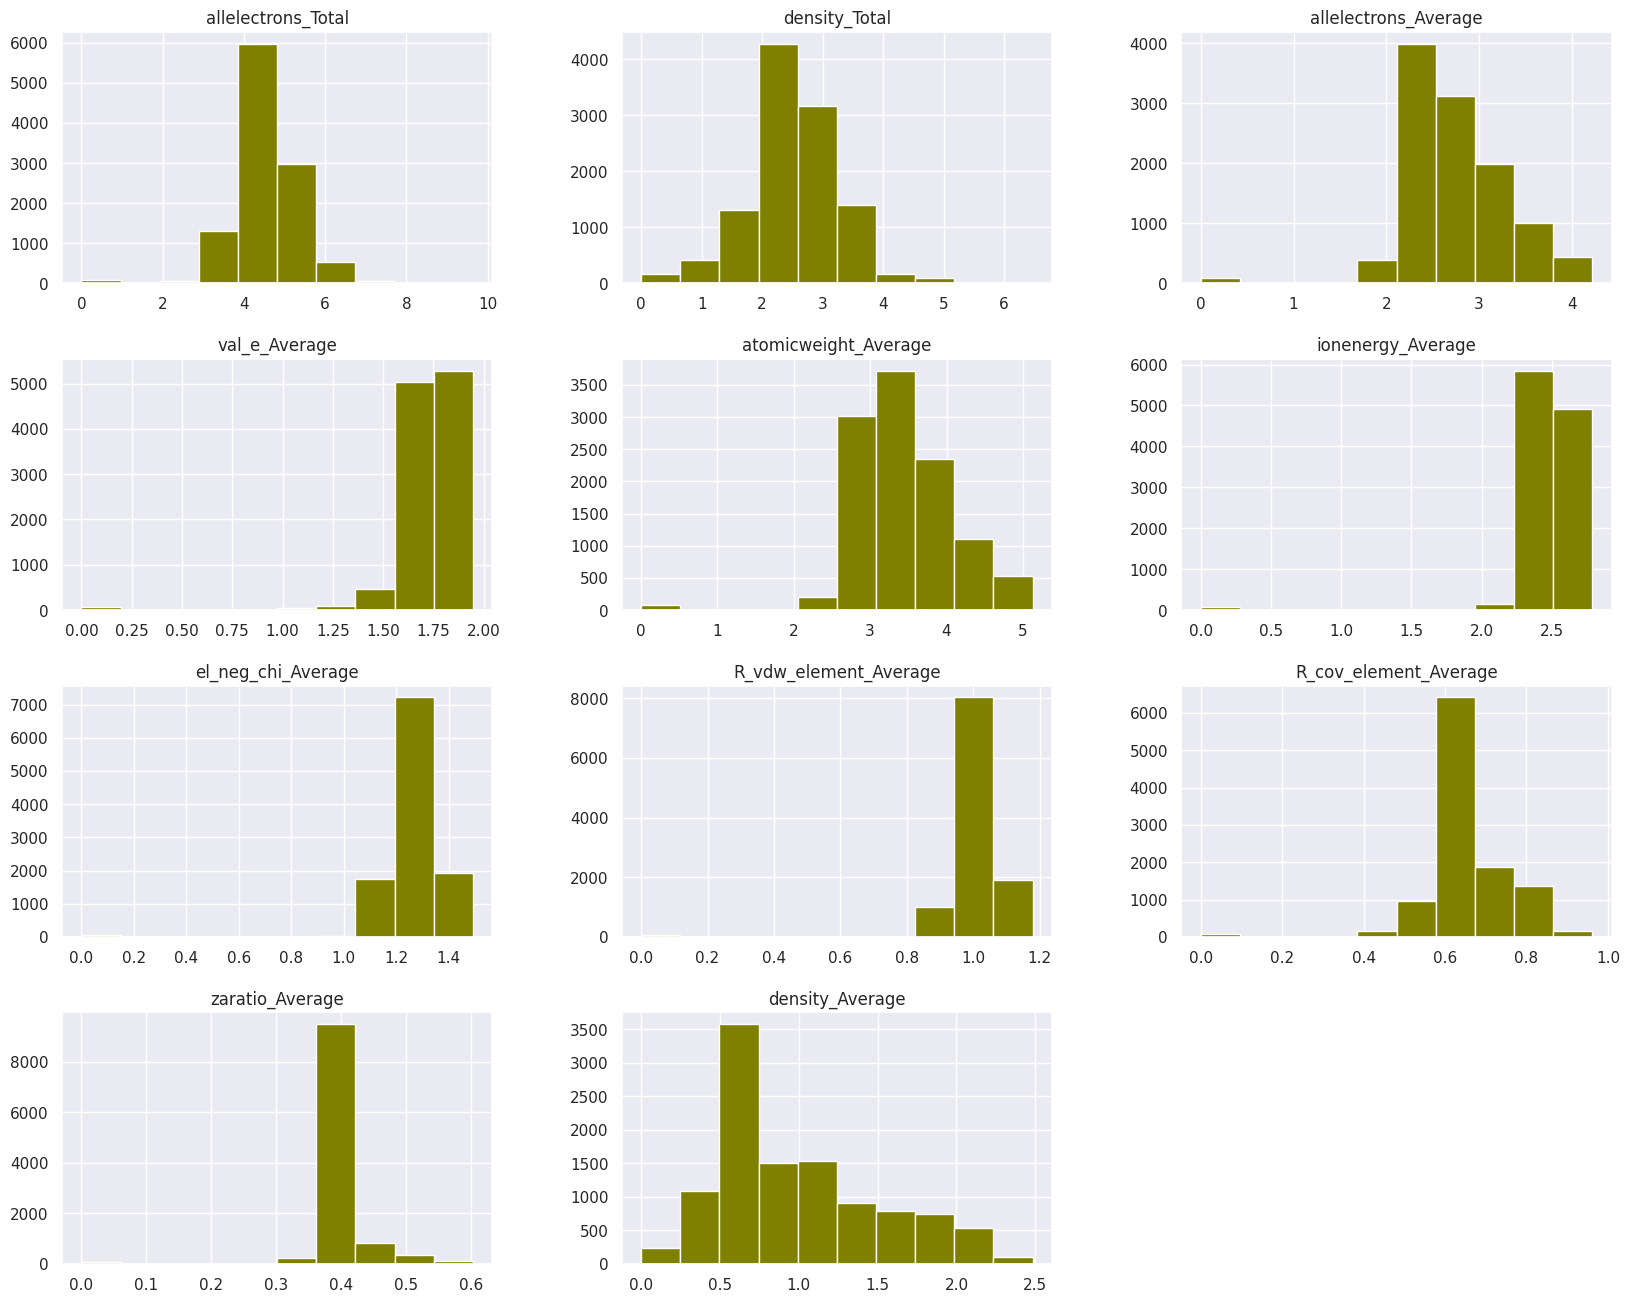

In [18]:
# Split the train data into X and y
X = train.drop(['Hardness'], axis=1)
y = train.Hardness

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))
    
# Transform test data
for column in test.columns.tolist():
    test[column] = test[column].apply(lambda x: np.log(x + 1))
    
X.hist(color='olive');

<a id='10.1'></a>
### <span style="color: brown">10.1 - Pie plot of Hardness</span>

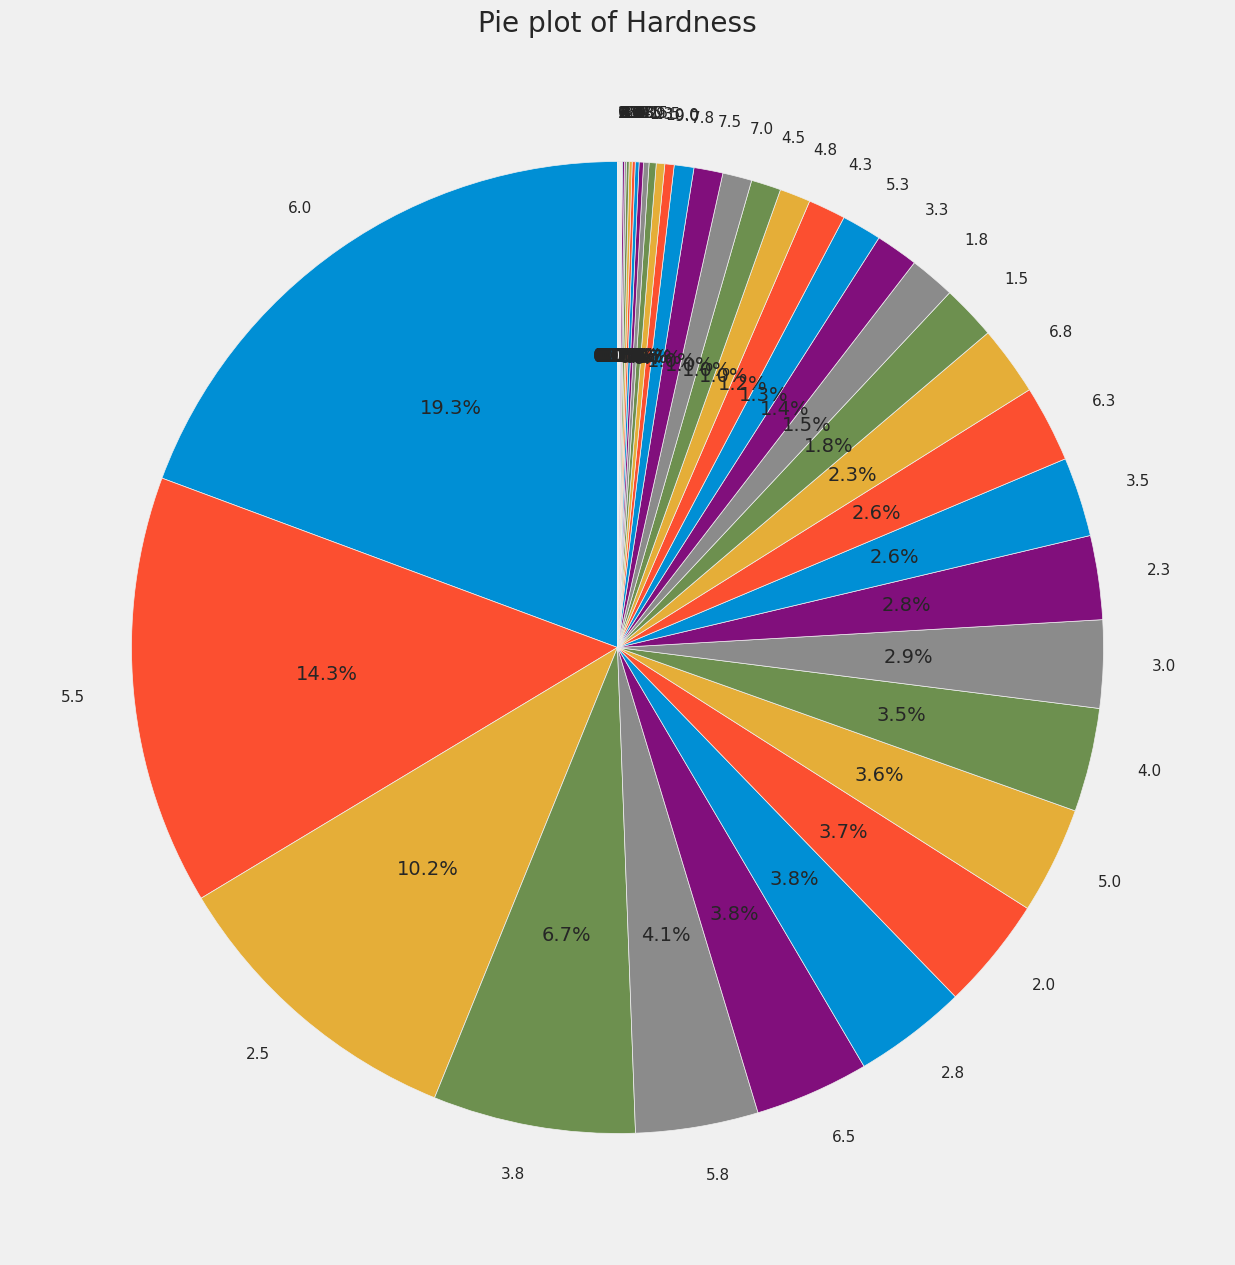

In [19]:
label_counts = y.value_counts()
plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 15))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Pie plot of Hardness')
plt.show();

<a id='10.2'></a>
### <span style="color: brown">10.2 Feature importance</span>

CPU times: user 9.33 s, sys: 108 ms, total: 9.44 s
Wall time: 9.37 s


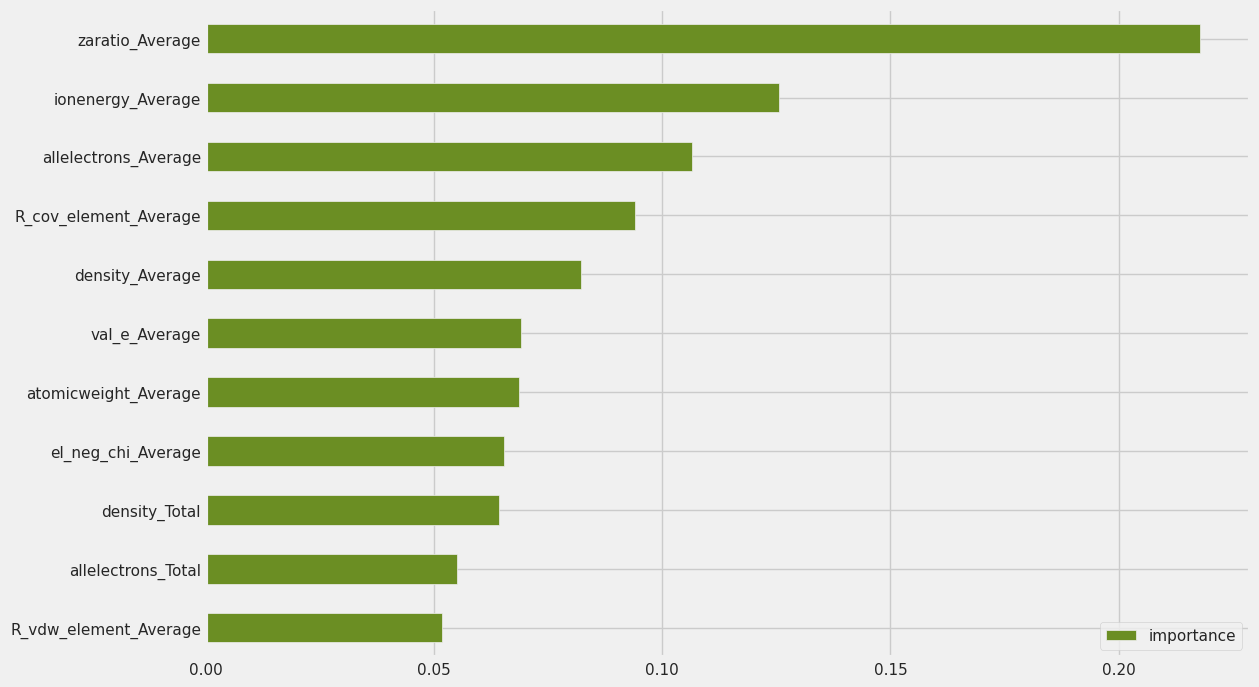

In [20]:
%%time
# I figured out best hyperparameters previously
best_forest = RandomForestRegressor(
    random_state=26,
)
    
best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='OliveDrab');


<a id='11'></a>
# <span style="color: brown">11 - Build a heat map of correlations</span>

In [21]:
correlation = X.corr()
correlation.style.background_gradient(cmap='Greens')

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
allelectrons_Total,1.000000,0.746072,0.360977,0.454941,0.382169,0.442747,0.409463,0.427726,0.304653,0.268399,0.194445
density_Total,0.746072,1.000000,0.546262,0.251807,0.551054,0.157953,0.131232,0.374229,0.381403,-0.011544,0.508791
allelectrons_Average,0.360977,0.546262,1.000000,0.322709,0.993781,0.172296,0.076554,0.683805,0.796836,-0.139404,0.794130
val_e_Average,0.454941,0.251807,0.322709,1.000000,0.357506,0.728488,0.720674,0.623490,0.411243,0.330322,0.034525
atomicweight_Average,0.382169,0.551054,0.993781,0.357506,1.000000,0.216438,0.120024,0.703797,0.798779,-0.106693,0.782727
ionenergy_Average,0.442747,0.157953,0.172296,0.728488,0.216438,1.000000,0.851527,0.591026,0.247878,0.697807,-0.118336
el_neg_chi_Average,0.409463,0.131232,0.076554,0.720674,0.120024,0.851527,1.000000,0.480494,0.136317,0.561325,-0.177026
R_vdw_element_Average,0.427726,0.374229,0.683805,0.623490,0.703797,0.591026,0.480494,1.000000,0.806240,0.240384,0.382997
R_cov_element_Average,0.304653,0.381403,0.796836,0.411243,0.798779,0.247878,0.136317,0.806240,1.000000,-0.071022,0.561643
zaratio_Average,0.268399,-0.011544,-0.139404,0.330322,-0.106693,0.697807,0.561325,0.240384,-0.071022,1.000000,-0.302364


#### <span style="color: ForestGreen">There is huge correlation between 'allelectrons_Average' and 'atomicweight_Average'. Maybe I have to drop second to avoid multicorrelation problem (second's feature importance is lower than first's)</span>

In [22]:
X = X.drop('atomicweight_Average', axis=1)
test = test.drop('atomicweight_Average', axis=1)

<a id='12'></a>
# <span style="color: brown">12 - Define base models</span>

In [23]:
# Searching for best parameters of XGBoost

# xgb_regressor = XGBRegressor(random_state=27)

# xgb_parameters = {
#     'n_estimators': range(50, 1000, 25),
#     'learning_rate': [0.001, 0.05, 0.01],
#     'max_depth': range(2, 20, 2),
# }

# xgb_random_search = RandomizedSearchCV(estimator=xgb_regressor, param_distributions=xgb_parameters, n_jobs=-1, cv=5)
# xgb_random_search.fit(X, y)
# xgb_random_search.best_params_

# {'n_estimators': 225, 'max_depth': 8, 'learning_rate': 0.05}  // competition data
{'n_estimators': 525, 'max_depth': 4, 'learning_rate': 0.05}  # // original + competition data

{'n_estimators': 525, 'max_depth': 4, 'learning_rate': 0.05}

In [24]:
# Searching for best parameters of CatBoost
# catboost_regressor = CatBoostRegressor(random_state=27)

# catboost_parameters = {
#     'iterations': range(50, 1000, 25),
#     'learning_rate': [0.001, 0.05, 0.1],
#     'depth': range(2, 16, 2),
# }

# catboost_random_search = RandomizedSearchCV(estimator=catboost_regressor, param_distributions=catboost_parameters, n_jobs=-1, cv=5)
# catboost_random_search.fit(X, y)
# catboost_random_search.best_params_

{'learning_rate': 0.05, 'iterations': 800, 'depth': 6}

{'learning_rate': 0.05, 'iterations': 800, 'depth': 6}

In [25]:
# # Searching for best parameters of LightGBM

# lgbm_regressor = LGBMRegressor(random_state=27)

# lgbm_parameters = {
#     'n_estimators': range(50, 1000, 25),
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': range(2, 20, 2),
# }

# lgbm_random_search = RandomizedSearchCV(estimator=lgbm_regressor, param_distributions=lgbm_parameters, n_jobs=-1, cv=5)
# lgbm_random_search.fit(X, y)
# lgbm_random_search.best_params_

{'n_estimators': 850, 'max_depth': 8, 'learning_rate': 0.01}

{'n_estimators': 850, 'max_depth': 8, 'learning_rate': 0.01}

In [26]:
# Searching for best parameters of RandomForestRegressor

# random_regressor = RandomForestRegressor(random_state=27)

# param_dist = {
#     'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth': [int(x) for x in np.linspace(10, 110, num=21)],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# random_search = RandomizedSearchCV(estimator=random_regressor, param_distributions=param_dist, n_jobs=-1, cv=5)
# random_search.fit(X, y)
# random_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 60,
 'bootstrap': True}

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 60,
 'bootstrap': True}

In [27]:
# Searching for best parameters of HistGradientBoostingRegressor

# HGB_regressor = HistGradientBoostingRegressor(random_state=27)

# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_iter': range(25, 1001, 25),
#     'max_depth': range(3, 100, 2),
#     'min_samples_leaf': [10, 20, 30],
# }

# random_search = RandomizedSearchCV(estimator=HGB_regressor, param_distributions=param_dist, n_jobs=-1, cv=5)
# random_search.fit(X, y)
# best_params = random_search.best_params_

{'min_samples_leaf': 30,
 'max_iter': 925,
 'max_depth': 91,
 'learning_rate': 0.01}

{'min_samples_leaf': 30,
 'max_iter': 925,
 'max_depth': 91,
 'learning_rate': 0.01}

In [28]:
# Searching for best parameters of ExtraTreesRegressor

# ETR_regressor = ExtraTreesRegressor(random_state=27)

# param_dist = {
#     'n_estimators': range(25, 1001, 25),
#     'max_depth': range(3, 100, 2),
#     'min_samples_leaf': [10, 20, 30],
# }

# ETR = RandomizedSearchCV(estimator=ETR_regressor, param_distributions=param_dist, n_jobs=-1, cv=5)
# ETR.fit(X, y)
# best_params = ETR.best_params_

{'n_estimators': 800, 'min_samples_leaf': 10, 'max_depth': 89}

{'n_estimators': 800, 'min_samples_leaf': 10, 'max_depth': 89}

In [29]:
# Searching for best parameters of AdaBoostRegressor

# AdaBoost_regressor = AdaBoostRegressor(random_state=27)

# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': range(25, 1001, 25),
# }

# AdaBoost = RandomizedSearchCV(estimator=AdaBoost_regressor, param_distributions=param_dist, n_jobs=-1, cv=5)
# AdaBoost.fit(X, y)
# best_params = AdaBoost.best_params_

{'n_estimators': 425, 'learning_rate': 0.01}

{'n_estimators': 425, 'learning_rate': 0.01}

In [30]:
# # Searching for best parameters of BaggingRegressor

# Bagging_regressor = BaggingRegressor(random_state=27)

# param_dist = {
#     'n_estimators': range(25, 1001, 25)
# }

# bagging = RandomizedSearchCV(estimator=Bagging_regressor, param_distributions=param_dist, n_jobs=-1, cv=5)
# bagging.fit(X, y)
# best_params = bagging.best_params_
# best_params

In [31]:
# # Searching for best parameters of GradientBoostingRegressor

# GB_regressor = GradientBoostingRegressor(random_state=27)

# param_dist = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_iter': range(25, 1001, 25),
#     'max_depth': range(3, 100, 2),
#     'min_samples_leaf': [10, 20, 30],
# }

# gb = RandomizedSearchCV(estimator=GB_regressor, param_distributions=param_dist, n_jobs=-1, cv=5)
# gb.fit(X, y)
# best_params = gb.best_params_
# best_params

In [32]:
# I'm 27 years old, that's why I use random_state=27
base_models = [
    ('catboost', CatBoostRegressor(
        iterations=800,
        learning_rate=0.05,
        depth=6,
        random_state=27
    )),
    ('xgboost', XGBRegressor(
        n_estimators=525,
        learning_rate=0.05,
        max_depth=4,
        random_state=27
    )),
    ('lightgbm', LGBMRegressor(
        n_estimators=850,
        learning_rate=0.01,
        max_depth=8,
        random_state=27
    )),
    ('randomforest', RandomForestRegressor(
        n_estimators=600,
        min_samples_split=2,
        min_samples_leaf=4,
        max_features='log2',
        max_depth=60,
        bootstrap=True,
        random_state=27
    )),
    ('HistGradientBoostingRegressor', HistGradientBoostingRegressor(
        min_samples_leaf=30,
        max_iter=925,
        max_depth=91,
        learning_rate=0.01
    )),
    ('ExtraTreesRegressor', ExtraTreesRegressor(
        n_estimators=800, 
        min_samples_leaf=10, 
        max_depth=89
    )),
    ('AdaBoostRegressor', AdaBoostRegressor(
        n_estimators=425, 
        learning_rate=0.01
    ))
]

<a id='13'></a>
# <span style="color: brown">13 - Defining the meta-model</span>

In [33]:
meta_model = XGBRegressor(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    random_state=27
)

![](https://laboratuar.com/images/iso-11125-2-metalik-puskurtmeli-temizleme-asindiricilari-icin-test-yontemleri---parcacik-boyutu-dagiliminin-belirlenmesi.jpg)

<a id='14'></a>
# <span style="color: brown">14 - Creating and fitting the stacking model

In [34]:
%%time
X_train, X_val, y_val, y_val = train_test_split(X, y, test_size=0.2, random_state=27)

stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
stacking_model.fit(X, y)

0:	learn: 1.6545837	total: 60.2ms	remaining: 48.1s
1:	learn: 1.6292809	total: 64.7ms	remaining: 25.8s
2:	learn: 1.6060342	total: 69.2ms	remaining: 18.4s
3:	learn: 1.5838807	total: 73.5ms	remaining: 14.6s
4:	learn: 1.5625438	total: 78.5ms	remaining: 12.5s
5:	learn: 1.5435439	total: 83.2ms	remaining: 11s
6:	learn: 1.5259511	total: 88ms	remaining: 9.97s
7:	learn: 1.5090675	total: 93.4ms	remaining: 9.25s
8:	learn: 1.4941477	total: 98.2ms	remaining: 8.63s
9:	learn: 1.4798732	total: 103ms	remaining: 8.1s
10:	learn: 1.4659560	total: 107ms	remaining: 7.64s
11:	learn: 1.4536715	total: 111ms	remaining: 7.27s
12:	learn: 1.4422910	total: 115ms	remaining: 6.97s
13:	learn: 1.4309180	total: 119ms	remaining: 6.7s
14:	learn: 1.4198545	total: 123ms	remaining: 6.46s
15:	learn: 1.4103422	total: 127ms	remaining: 6.24s
16:	learn: 1.4017979	total: 132ms	remaining: 6.08s
17:	learn: 1.3937983	total: 136ms	remaining: 5.91s
18:	learn: 1.3863088	total: 140ms	remaining: 5.74s
19:	learn: 1.3793355	total: 143ms	rema

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [21:52:59] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "depth", "iterations" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 5min 25s, sys: 32.4 s, total: 5min 57s
Wall time: 4min 45s


StackingRegressor(estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7a4809dd31f0>),
                              ('xgboost',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_...
                                               feature_types=None, gamma=None,
                                               grow_policy=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               iterations=800,
                                               learning_rate=0.05, max_bin=None,
                                               max_cat_threshold=None,
                                               max_cat_to_onehot=None,
                                               max_delta_step=None,
                                               max_depth=None, max_leaves=None,
                                               min_child_weight=None,
                                               missing=nan,
                                               monotone_constraints=None,
                                               multi_strategy=None,
                                               n_estimators=None, n_jobs=None, ...))

<a id='15'></a>
# <span style="color: brown">15 - Predict the validation set and calculate Median Absolute Error score</span>

In [35]:
y_pred_val = stacking_model.predict(X_val)

medae_val = median_absolute_error(y_val, y_pred_val)
print(f"Validation Median Absolute Error: {medae_val:.4f}")

Validation Median Absolute Error: 0.4554


<a id='16'></a>
# <span style="color: brown">16 - Predict on the test data</span>

In [36]:
y_pred_test = stacking_model.predict(test)
y_pred_test[:10]

array([2.7125366, 2.8174374, 6.1290574, 3.9732819, 5.306436 , 4.6784816,
       3.5862896, 5.230324 , 3.1487935, 4.922003 ], dtype=float32)

<a id='17'></a>
# <span style="color: brown">17 - Build DataFrame and make first submission</span>

In [37]:
submission = pd.DataFrame({
    'id': sample_submission.id,
    'Hardness':y_pred_test
})

submission.to_csv('Kapturov_S3E25_submission.csv', index=False)
submission.head()

,id,Hardness
0,10407,2.712537
1,10408,2.817437
2,10409,6.129057
3,10410,3.973282
4,10411,5.306436


![](https://terracotta.by/upload/iblock/626/2mbuqiuhyl9bywxjpyysgyu35k2r9i1u.jpg)